In [1]:
import requester
import pandas as pd
import math
import datetime
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import collections

In [2]:
now = datetime.datetime.now()
currentYear = now.year

genres = ['mecha', 'historical', 'music']
items = []
for g in genres: 
    items.append(pd.read_csv(requester.base + g + '.csv', sep=';')) # read csv file with animes 
items = pd.concat(items)
items.head()

id                                 name   year    type         genres  \
0   3784   Evangelion__20_You_Can_Not_Advance   2009   Movie          mecha   
1     30              Neon_Genesis_Evangelion   1996      TV          mecha   
2   3785      Evangelion__30_You_Can_Not_Redo   2012   Movie          mecha   
3   3572                            Macross_F   2008      TV   mecha, music   
4  30749             Saijaku_Muhai_no_Bahamut   2016      TV          mecha   

   episodes rating       source           status  
0         1   8.49     Original   FinishedAiring  
1         2   8.31     Original   FinishedAiring  
2         1   7.68     Original   FinishedAiring  
3         2   8.01     Original   FinishedAiring  
4         2   6.87   Lightnovel   FinishedAiring

# Animes position in 3D space 

In [3]:
initValue = dict()
initValue['mecha'] = (30,30)
initValue['historical'] = (60,60)
initValue['music'] = (90,30)

def getInitPos(genres):
    genres = genres.split(',')
    xSum, ySum = 0, 0
    for g in genres:
        x, y = initValue[g.strip()]
        xSum += x
        ySum += y
    x = xSum/len(genres)
    y = ySum/len(genres)
    return x, y, 0

def yearInfluence(year):
    if isinstance(year, str) and 'available' in year:
        return 0
    year = int(year)
    deltaYear = year - currentYear
    deltaY = deltaYear * 0.3
    return deltaY

def sourceAndRatingInfluence(source, rating):
    if isinstance(rating, str) and 'N/A' in rating: 
        return -100
    rating = float(rating)
    if 'Original' in source:
        deltaZ = 1.3 * (rating - 7)
    elif 'Manga' in source or 'Webmanga' in source: 
        deltaZ = 1.3 * (rating - 5)   
    elif '4-komamanga' in source: 
        deltaZ = 1.4* (rating - 5)
    elif 'Lightnovel' in source:
        deltaZ = 1.5 * (rating - 7)
    elif 'Novel' in source:
        deltaZ = 2.5 * (rating - 7)
    elif 'Visualnovel' in source:
        deltaZ = 3.5 * (rating - 7)
    elif 'Game' in source:
        deltaZ = 3.6 * (rating - 7)
    elif 'Cardgame'in source:
        deltaZ = 3.7 * (rating - 7)
    elif 'Music' in source:
        deltaZ = 5 * (rating - 7)
    else: # 'Other' or 'Unknown'
        deltaZ = 6 * (rating - 7)
    return deltaZ

def typeAndEpsInfluence(type_, eps):
    if 'OVA' in type_ or 'ONA' in type_:
        deltaX = -3
    elif 'TV' in type_:
        if eps == 0:
            deltaX = -100 # not aired
        elif eps == 2:
            deltaX = 2 # short
        elif eps == 3:
            deltaX = 1 # medium
        else:
            deltaX = 0 # large
    elif 'Special' in type_:
        deltaX = -2
    elif 'Movie' in type_:
        deltaX = 3
    else: 
        deltaX = -4
    return deltaX
    
def getPos(genres, eps, rating, year, type_, source):
    x, y, z = getInitPos(genres)
    z += sourceAndRatingInfluence(source, rating)
    y += yearInfluence(year)
    x += typeAndEpsInfluence(type_, eps)
    return x, y, z
    

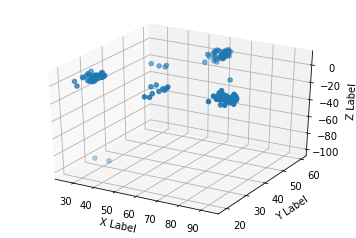

In [4]:
xAxis = []
yAxis = []
zAxis = []
points = dict()
for index, row in items.iterrows():
    x, y, z = getPos(row['genres'], row['episodes'], row['rating'], row['year'], row['type'], row['source'])
    xAxis.append(x)
    yAxis.append(y)
    zAxis.append(z)
    points[row['id']] = (x, y, z)
    
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xAxis, yAxis, zAxis)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

# Dendrogram 

In [5]:
def initClusters(points):
    clusters = dict()
    i = 0
    for id_, pos in points.items():
        clusters[i] = [(id_, pos)] # [(id_, (x, y, z))]
        i = i + 1
    return clusters

In [6]:
def joinClusters(minDist, cluster, count, matrix, index):
    d, i, j = minDist # juntar e remover um dos clusters antigos
    minI = min(i, j)
    maxJ = max(i, j)
    i = minI
    j = maxJ
    list1 = cluster[i]
    list2 = cluster[j]
    newList = []
    newList.append(list1)
    newList.append(list2)
    cluster[i] = newList
    
    matrix.append([index[i], index[j], d, len(toList(newList))])
    index[i] = count 
    count += 1
    
    del cluster[j]
    return cluster, count

def distancePoints(x1, y1, z1, x2, y2, z2):
    return abs(x1-x2) + abs(y1-y2) + abs(z1-z2)
    
def toList(list_):
    if not type(list_) is list:
        return list_
    l = len(list_)
    newList = []
    for i in range(0, l):
        el = toList(list_[i])
        if type(el) is list:
            newList += el
        else:
            newList.append(el)
    return newList

def distanceClusters(i, j, cluster1, cluster2, standard):
    cluster1_ = toList(cluster1)
    cluster2_ = toList(cluster2)
    distances = []
    for item1 in cluster1_:
        pos1 = item1[1]
        for item2 in cluster2_:
            pos2 = item2[1]
            d = distancePoints(*pos1, *pos2)
            distances.append(d)
    d = standard(distances)
    return d

def iterateClusters(clusters, count, matrix, index, standard):
    dist = []
    for i, items1 in clusters.items():
        for j, items2 in clusters.items():
            if i > j:
                d = distanceClusters(i, j, items1, items2, standard)
                dist.append((d, i, j))
    minDist = min(dist)
    clusters, count = joinClusters(minDist, clusters, count, matrix, index)
    return clusters, count

def hierarchicalClustering(points, standard):
    clusters = initClusters(points)
    count = len(clusters)
    matrix = []                            # matrix used to print dendogram (saves steps)
    index = dict()                         # saves current cluster number of key
    for i in range(0, count):
        index[i] = i
    
    while len(clusters) > 1:
        clusters, count = iterateClusters(clusters, count, matrix, index, standard)
    return matrix, clusters

In [7]:
matrix, clusters = hierarchicalClustering(points, max)

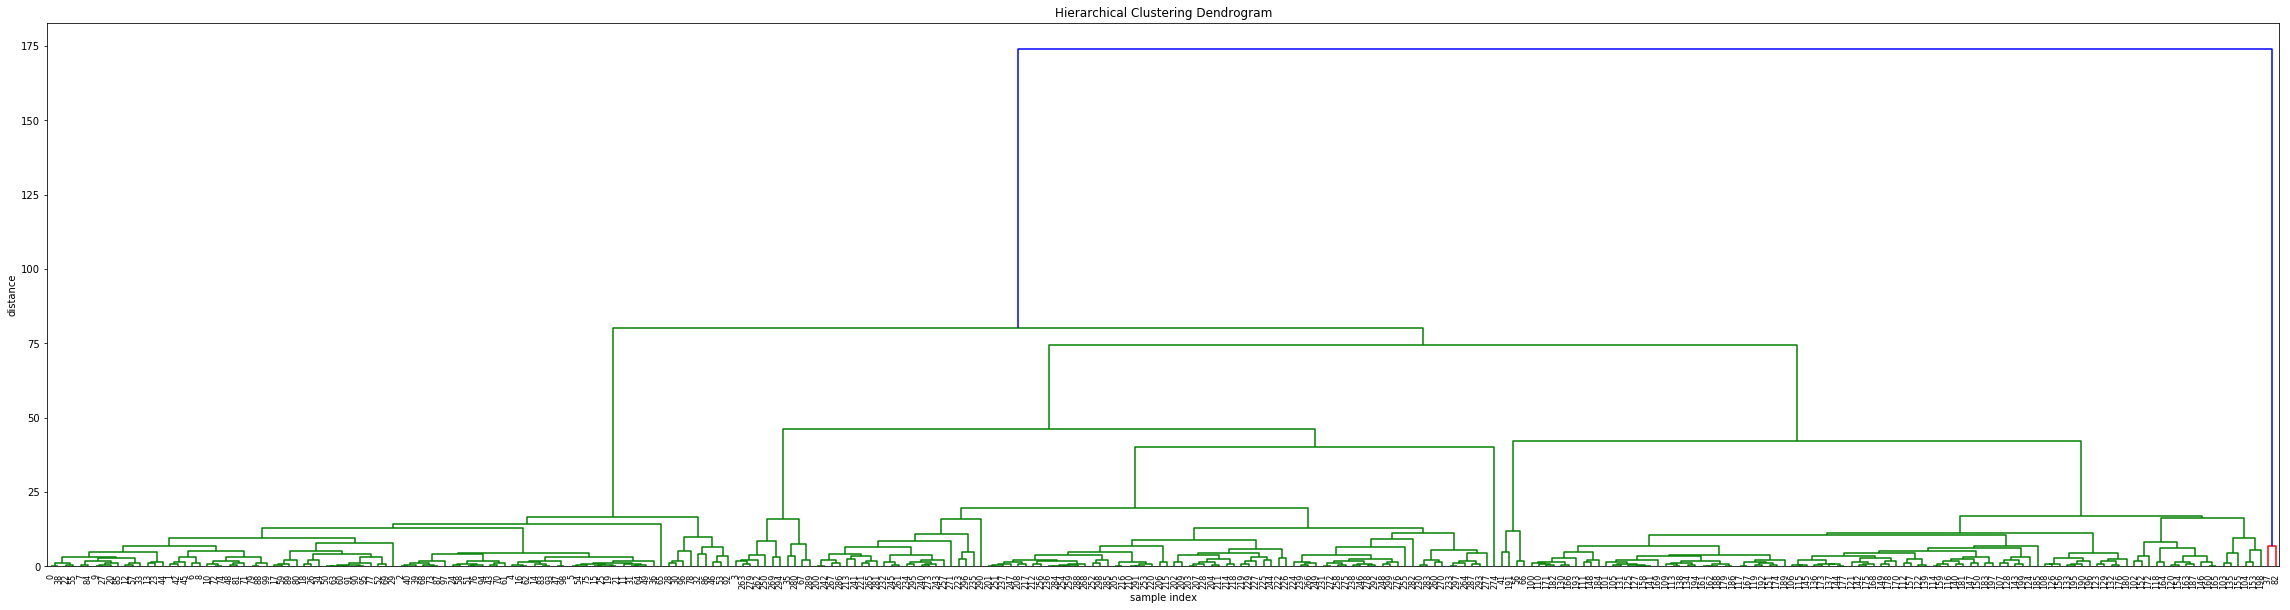

In [8]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
#matrix
#for i, items1 in clusters.items():
#    print(items1)
plt.figure(figsize=(40, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    matrix,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

In [9]:
clusters[0]

[[[[[[[[[[[[(3784, (33.0, 27.6, 1.9370000000000003))],
           [(4565, (33.0, 27.6, 2.119000000000001))]],
          [[(2759, (33.0, 27.0, 1.5469999999999995))],
           [(4107, (33.0, 27.3, 1.586000000000001))]]],
         [[[[(73, (32.0, 26.4, 1.575000000000001))],
            [(411, (32.0, 26.4, 2.160000000000002))]],
           [[[[(2001, (32.0, 27.0, 2.288))],
              [(1575, (32.0, 27.0, 2.3530000000000006))]],
             [(2904, (32.0, 27.3, 2.5480000000000014))]],
            [(143, (32.0, 26.1, 2.6390000000000002))]]],
          [[[(2581, (32.0, 27.3, 1.5990000000000006))],
            [(3927, (32.0, 27.6, 1.5599999999999992))]],
           [(2002, (32.0, 27.0, 0.8450000000000005))]]]],
        [[[(237, (31.0, 26.7, 1.521))],
          [(93, (31.0, 25.8, 1.1830000000000003))]],
         [(94, (31.0, 26.4, 0.44199999999999984))]]],
       [[[[[(30, (32.0, 23.7, 1.7030000000000007))],
           [(182, (32.0, 23.7, 1.0270000000000001))]],
          [(90, (31.0, 23.

In [10]:
def clearDendo(clusters):
    if not type(clusters) is list:
        return clusters[0]
    else:
        l = len(clusters)
        for i in range(0, l):
            clusters[i] = clearDendo(clusters[i])
        return clusters

In [11]:
d = clearDendo(clusters[0])

In [12]:
d

[[[[[[[[[[[[3784], [4565]], [[2759], [4107]]],
         [[[[73], [411]], [[[[2001], [1575]], [2904]], [143]]],
          [[[2581], [3927]], [2002]]]],
        [[[237], [93]], [94]]],
       [[[[[30], [182]], [90]], [[31], [32]]],
        [[[[71], [[167], [567]]], [[[98], [478]], [109]]],
         [[[58], [180]], [393]]]]],
      [[[[[[19775], [24893]], [22433]], [12471]],
        [[[[467], [801]], [1690]],
         [[[[[[6772], [8514]], [[9252], [9465]]], [[9724], [10092]]], [4672]],
          [[468], [54]]]]],
       [43]]],
     [[[[[[[3785], [8888]], [15197]], [[13391], [[15201], [15199]]]], [6288]],
       [[[[9041], [8934]], [[[10447], [11021]], [11227]]],
        [[[5342], [6676]], [2795]]]],
      [[[[[30749], [[31338], [32023]]], [[18247], [[21677], [23133]]]],
        [[31318], [31790]]],
       [[[[[[16668], [18295]], [21437]],
          [[[16524], [15583]], [[19163], [22729]]]],
         [[27655], [[[27829], [32245]], [25731]]]],
        [31251]]]]],
    [80]],
   [[[[[227],

In [13]:
file = open("dendrogram.py", 'w')
file.write('dendrogram =' + str(d))
file.close()